# Deep Learning - *SS19 - 27.06.2019*
# 1D-CNN Tutorial 02: Sequential in Keras

## Table of Contents
- [Introduction](#introduction)<br>
- [1D-CNN sequential classification](#cnn_sequential_classification)<br>
    - [Load packages](#load_packages)<br>  
    - [The dataset](#the_dataset)<br>  
    - [Load the data](#load_the_data)<br> 
    - [Data exploration](#data_exploration)
    - [Build model](#build_model)<br>
    - [Evaluation data](#evaluation_data)<br>
    - [Prediction](#prediction)<br>
- [Compromise](#compromise)<br>
- [Summary](#summary)<br>
- [References](#references)<br>

## Introduction <a id="introduction"></a>
Most use cases for 1D-CNN models are those where sequential data sets are used. These are often sensor data measured in a defined time interval. For example, temperature, humidity or wind force are read in and analyzed, but also texts, as shown in Notebook "1D-CNN Tutorial 01: Simple 1D-CNN in Keras". The used texts have to be converted into a suitable format (one-hot vectors) before being used in a 1D-CNN, after that they can be used like other sequential data. In this second notebook to 1D-CNN we will concentrate on the classical use of 1D-CNN, i.e. the analysis of numerical values. 
The example, which we will examine in more detail in the following, as well as the corresponding data sets are taken from a Kaggle competition. Kaggle is an online community of data scientists and enables users to find or publish data sets. However, the platform also offers the opportunity to explore or create models in a web-based data science environment, to collaborate with other data scientists and engineers, and to participate in competitions to solve data science challenges. Klagge offers its users a wide range of interesting content in this area, including competitions for machine learning, a public data platform, a cloud-based workbench for data science and a short form of AI-training. On March 8, 2017, Google announced that they would acquire Kaggle. 


The competition, which is interesting for us, deals with the subject of earthquakes. Current scientific studies in connection with earthquake forecasting concentrate on three key points: When the event will occur, where it will occur and how big it will be. The analysis of seismic signals is used to predict the time of an earthquake. Due to their devastating consequences, the prediction of earthquakes is one of the most important problems in the geosciences. 
The aim of the Klagge competition is to create a model that can predict the time span until an earthquake from real-time data. In this notebook, only the training and test data provided will be discussed. The data we will use originates from a known experimental setup for the investigation of earthquake physics. More information about the competition can be found at the following link: https://www.kaggle.com/c/LANL-Earthquake-Prediction (The last check of the link took place on 8. June 2019).

## 1D_CNN_text_classification 1D-CNN sequential classification<a id="cnn_sequential_classification"></a>

### Load packages<a id="load_packages"></a>
Load all required packages for data manipulation, feature engineering and model training.

In [1]:
from __future__ import print_function
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#data visualization
import matplotlib.pyplot as plt
#host-os operations
import os
from os import listdir, makedirs, path
from os.path import isfile, join, basename, splitext, isfile, exists
from pathlib import Path
#import keras.utils as utils
from tqdm import tqdm_notebook
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Embedding, GlobalAveragePooling1D
from keras.optimizers import adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras import optimizers
# Graphic output
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### The dataset<a id="the_dataset"></a>

The training data is a single, continuous segment of seismic signals. The test data consists of a folder with many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment. Thus, it cannot be assumed that the predictions follow the same regular pattern as in the training file.

**Notice that:** The training and test data are in the zip file "LANL-Earthquake-Prediction" and must be **incorporated into the project structure and unpacked**! After unpacking the test data, the following files or folders should be available: ['test', 'sample_submission.csv', 'train.csv']. The folder "test" should contain at least 2.624 files. Another note: From time to time Jupiter also creates a checkpoint file, so there may be 2.625 files.

In [2]:
Earthquake_Prediction = Path('LANL-Earthquake-Prediction')
Test = Path('LANL-Earthquake-Prediction/test/')
if Earthquake_Prediction.is_dir() and Test.is_dir():
    print('Data already available')
else:
    import zipfile
    zip_ref = zipfile.ZipFile('LANL-Earthquake-Prediction.zip', 'r')
    zip_ref.extractall('LANL-Earthquake-Prediction')
    zip_ref.close()

Data already available


We then check that all the data is correct. The project directory should now contain a folder called "LANL-Earthquake-Prediction". In this directory you should find the following folders/files:
- **sample_submission.csv**: Example prediction file  
- **test**: Folder with the test sequences
- **train.csv**: File with the training data


In [3]:
print(os.listdir('LANL-Earthquake-Prediction'))
print("There are {} files in test folder".format(len(os.listdir(os.path.join('LANL-Earthquake-Prediction', 'test' )))))

['sample_submission.csv', 'test', 'train.csv']
There are 2624 files in test folder


File descriptions:
- **train.csv:** A single, continuous training segment for experimental data
    <br>Data fields:
    - `acoustic_data` - The seismic signal [int16]
    - `time_to_failure` - Time (in seconds) to the next laboratory earthquake [float64]
<br><br>
- **test:** A folder with many small segments of test data
    - `seg_id` - The test segment for which predictions are to be made (one prediction per segment)
<br><br>
- **sample_sumbission.csv:** An example file (prediction) in the correct format

### Load data <a id="load_the_data"></a>

In [4]:
num_sequences = 629000000
sequence_length= 50000
num_features = 1
batch_size = 128
epochs = 100
path_trainData = 'LANL-Earthquake-Prediction/'
path_testData = 'LANL-Earthquake-Prediction/test/'

Explanation:
- **num_sequences:** Number of data sets to be loaded from the training data (the larger, the more training data sets we have, but the longer it takes to train the model)
- **sequence_length:** Length of the training sequences (The huge sequence is divided into x blocks of the length `sequence_length`)
- **num_features:** Number of channels of our model (1: Since there is only one "huge" sequence)
- **path_***: Path specifications

If an out-of-memory error occurs, the `num_sequences` and `sequence_length` can be set to a smaller value at this point. This reduces the recognition rate of the model, but it can also be trained on weaker machines.

In [5]:
load_data = pd.read_csv(path_trainData+'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

The file train.csv contains our training data. It consists of more than 600 million data rows and two columns (`acoustic_data` and `time_to_failure`). Importing the file may take a few minutes (about five minutes). To see if the dataset has been imported correctly, we will display the first and last ten data fields.

In [6]:
print(load_data.head(10))
print('\n')
print(load_data.tail(10))

   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
5              8           1.4691
6              9           1.4691
7              7           1.4691
8             -5           1.4691
9              3           1.4691


           acoustic_data  time_to_failure
629145470              6         9.759796
629145471              2         9.759796
629145472              3         9.759796
629145473              6         9.759796
629145474              5         9.759796
629145475              7         9.759796
629145476              9         9.759796
629145477             10         9.759796
629145478              6         9.759796
629145479              5         9.759796


#### Data exploration <a id="data_exploration"></a>

The `acoustic_data` (red) represent the seismic data, the `time_to_failure` (blue) the time until an earthquake occurs. From this diagram we can clearly see that if an earthquake has occurred, the `acoustic_data` has extremely deflected shortly before. It is also possible to see that the higher the `time_to_failure` deflection after an earthquake, the longer it takes for the next earthquake to occur. The plot represents only every 100 data sets of the data set. [[1]](#r1),[[5]](#r5),[[7]](#r7)




In [7]:
n_step = 100
train_ad_sample_df = load_data['acoustic_data'].values[::n_step]
train_ttf_sample_df = load_data['time_to_failure'].values[::n_step]

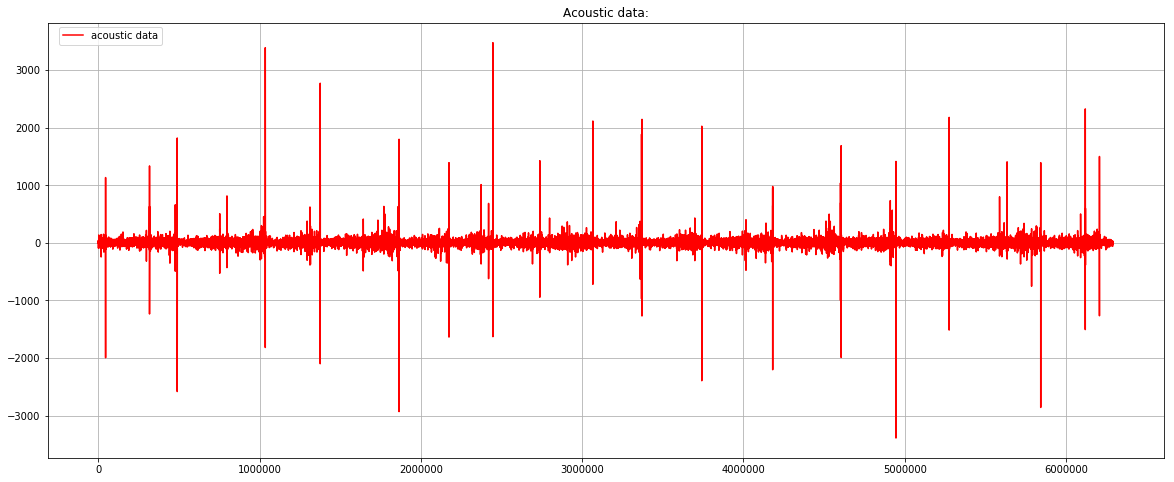

In [8]:
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title('Acoustic data:')
plt.plot(train_ad_sample_df, color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
plt.grid(True)

Let's have a look at the data first. Initially we look at the `acoustic_data` data. These are the individual swings of seismic activity and there are no conspicuous features.

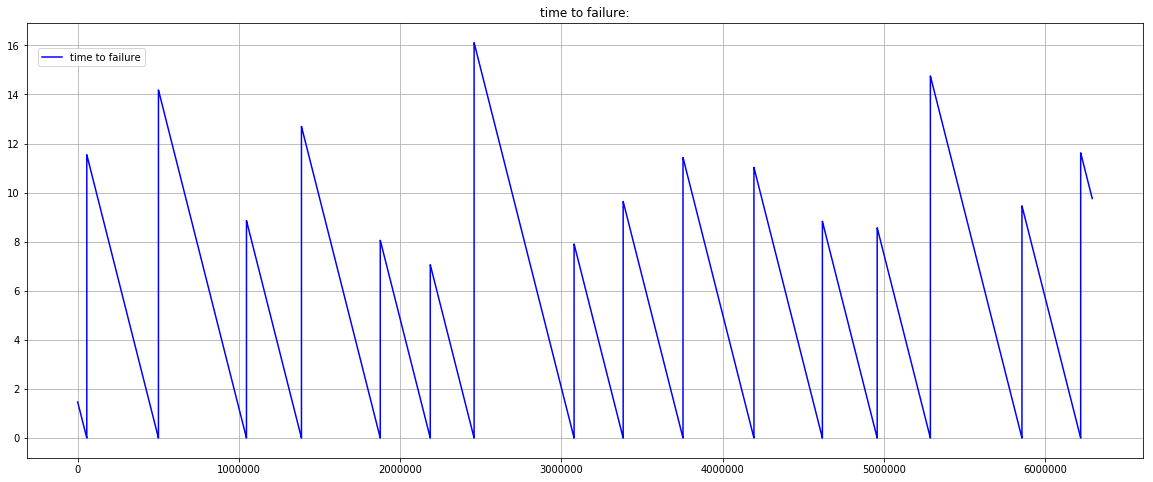

In [9]:
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title('time to failure:')
plt.plot(train_ttf_sample_df, color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)
plt.show()

In the second step we want to look at `time_to_failure`. We see that it is a sequence of values, which are minimized by a positive start value step by step, until they reach the value 0. Then a positive start value is set again and the cycle starts again.
`time_to_failure` specifies the time at one point of the sequence until an earthquake occurs from this point on.

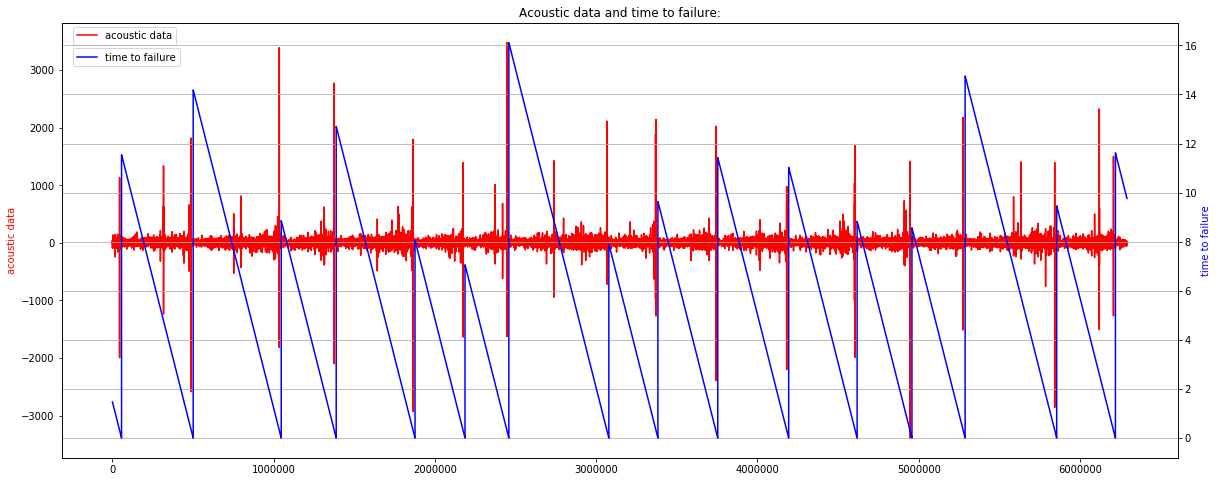

In [10]:
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title('Acoustic data and time to failure:')
plt.plot(train_ad_sample_df, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(train_ttf_sample_df, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)
plt.show()

In the last step of this section, we will look at both dates in relation to each other. Here it is noticeable that the `time_to_failure` data does not end at 0 as in the diagram above (i.e. an earthquake is triggered), but at a negative value. However, this is due to the plotting of the diagram. The data has not changed! Nevertheless, this can lead to misunderstandings. We find that when an earthquake occurs (time_to_failure = 0), the seismic activity (accustic_data) has large swings at the same time.

If you are interested in how the training and test earthquakes occur, you can find out more in the following video:

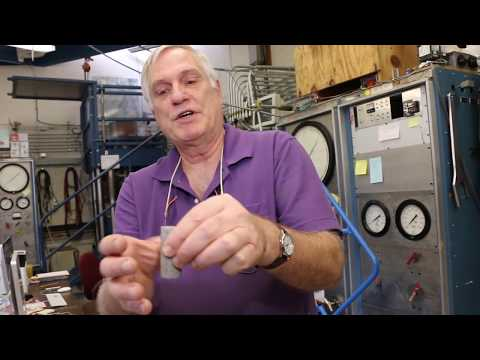

In [11]:
from IPython.display import YouTubeVideo
YouTubeVideo('m_dBwwDJ4uo')

### Build model<a id="build_model"></a>

In this section, we will perform all required preprocessing of the data and generate our model to analyze the data.

The training file was read in the **Load Data** section. However, this one training file is too large and contains too much information to be used for training. Therefore, the information is first separated from each other and then divided into blocks of equal size.
- Separate the columns of the training file from each other (acoustic_data && time_to_failure)
- Now the training data will be divided into blocks of equal size 
    - X_train consists of three outputs:  &lt;Number of Sequence (acoustic_data) && Sequence length && Number of channels&gt;
    - Y_train consists of three outputs:   &lt;Number of Sequence (time_to_failure) && Sequence length && Number of channels&gt; <br> Here only the "time_to_failure" data is needed to label our X_train data, so that Y_train can be formatted to a one dimensional array
    
One of the most important things is what the model should learn. In our case, we want the model to predict when an earthquake will occur. We have some test data to prove our model. At the end of this notebook, the model should load the test data and make a prediction for each test file when an earthquake will occur, starting from the beginning of the file.

Our model should therefore recognize when an earthquake occurs by using the seismic acoustic data read in. This has the following consequences for us: First, we divide our training sequence into blocks of different sizes of the length `sequence_length`. Each of the blocks contains a sequence of acoustic data, which means a coherent structure. We also know for each `aucustic_data` its `time_to_failure`. If we have a sequence of aucustic_datas and a sequence of time_to_failure we can tell how long a certain structure or sequence of swings is distant from an earthquake. 

That's what we want to make use of. However, since each sequence block in X_train can only have one label, we have decided on the following procedure: If an earthquake occurs in a sequence block, it gets the label 0. 0 means that an earthquake has occurred. We can calculate this by using the following formula: Take the first and last element from the sequence block and compare both values (Attention: Float values --> compare epsilon!).
The first element describes the time at the start of the sequence, the last the time at the end of the sequence until an earthquake. If the value is greater than 0, there is no earthquake in this sequence, otherwise there was an earthquake. In case there is no earthquake, we want to calculate an average time for the sequence block that this sequence block has until an earthquake. Since it would be too complicated to calculate the median, we use the following method: We add the first and the last element of the block together and divide them by 2. This gives us a relatively useful mean value.


In [12]:
train = load_data[:num_sequences]

In [13]:
#Training data for 1D-CNN
X_train = train['acoustic_data'].values
Y_train = train['time_to_failure'].values
print(X_train.shape,Y_train.shape)

#Read values and reshape
X_train = X_train.reshape(-1,sequence_length,num_features)
Y_train = Y_train.reshape(-1,sequence_length,num_features)

#
mean = np.zeros(len(Y_train), dtype = float) 
for i in range(len(Y_train)):
    if(abs(Y_train[i][0]-Y_train[i][-1]) < 0.0000001):
        mean[i] = 0
    else:
        mean[i] = (float(Y_train[i][0])+float(Y_train[i][-1]))/2
        
Y_train = np.float32(mean) 
print(X_train.shape,Y_train.shape)

(629000000,) (629000000,)
(12580, 50000, 1) (12580,)


After the data has been formatted, the model can now be created. Since the data set consists only of numerical values which do not have or need a spatial relationship to each other, an embedding layer can be dropped and the data can be transferred directly into a convolution layer. Please note that the first convolution layer needs the `input_shape` argument. The `input_shape` argument needs the **sequence length** and the **number of channels**. At this point there are 100 ways to build the model. The following is a simple model:

The model is designed in such a way that the input data passes through a convolution layer twice and then a pooling process selects the best results. `MaxPooling1D` checks all channels of the previously created convolution for a value that is larger and takes this value. `GlobalAveragePooling1D` determines an average value from all channels and then checks the channels and takes the value closer to this average value. Then a dropout is executed and then everything is pressed into a dense layer. [[2]](#r2),[[3]](#r3)

- Larger filter -> More learnable features and therefore better results, but the better hardware is needed
-  All convolution pairs should have the same number of filters (since pooling is performed on the convolution pair and the better one is selected), but the filters of the next convolution pair must be at least 1 larger than the convolution pair before.

In [14]:
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=10, activation='relu',strides=5, input_shape=(sequence_length, num_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=200, kernel_size=10, activation='relu',strides=5))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=400, kernel_size=10, activation='relu',strides=5))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4))
#print(model.summary())

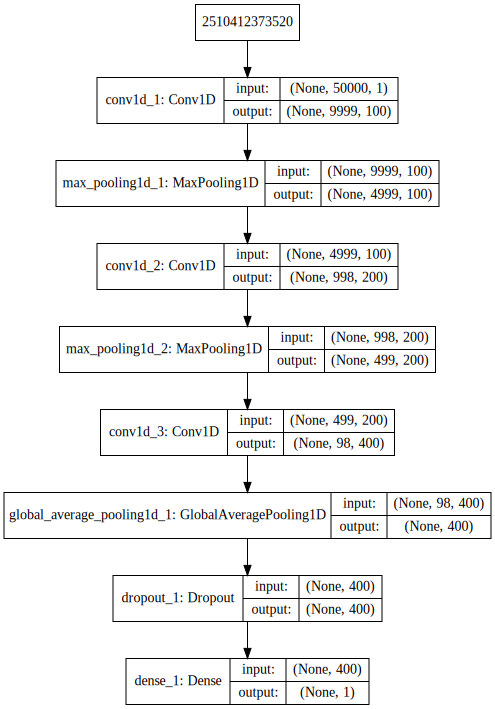

In [15]:
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

In [16]:
history = model.fit(X_train, Y_train.reshape(-1,1), batch_size=batch_size, epochs=epochs, validation_split=0.3, verbose = 1,
                    callbacks = [
                        EarlyStopping(monitor='val_loss',patience=15, verbose=1, mode='min'),
                        ModelCheckpoint(filepath='1d_cnn_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1),
                        ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=1,min_delta=1e-4,mode='min')])

Train on 8806 samples, validate on 3774 samples
Epoch 1/100
8806/8806 [==============================] - 22s 3ms/step - loss: 3.1571 - val_loss: 2.6873

Epoch 00001: val_loss improved from inf to 2.68730, saving model to 1d_cnn_model
Epoch 2/100
8806/8806 [==============================] - 16s 2ms/step - loss: 2.5749 - val_loss: 2.5887

Epoch 00002: val_loss improved from 2.68730 to 2.58870, saving model to 1d_cnn_model
Epoch 3/100
8806/8806 [==============================] - 17s 2ms/step - loss: 2.4403 - val_loss: 2.5343

Epoch 00003: val_loss improved from 2.58870 to 2.53427, saving model to 1d_cnn_model
Epoch 4/100
8806/8806 [==============================] - 17s 2ms/step - loss: 2.4166 - val_loss: 2.5038

Epoch 00004: val_loss improved from 2.53427 to 2.50380, saving model to 1d_cnn_model
Epoch 5/100
8806/8806 [==============================] - 17s 2ms/step - loss: 2.4169 - val_loss: 2.4763

Epoch 00005: val_loss improved from 2.50380 to 2.47632, saving model to 1d_cnn_model
Epoch 

The weights of the network are stored automatically. In this model, however, the weight of the model is stored only when the validation loss has improved from the last stored validation loss. This allows you to train the model over a longer period of time without losing optimal weighting.  On the other hand, an overadaptation of the prediction model is prevented, since the validation_lost is not improved and therefore not saved if the training net is overadapted. At this point it is not worth saving the entire model or loading it later. For more information see section [Prediction](#Prediction).

Arguments:
- **verbose:** Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
- **callbacks:** List of keras.callbacks.Callback instances. List of callbacks to apply during training and validation (if ).
    - **ModelCheckpoint:** Save the model after every epoch.
    - **EarlyStopping:** Stop training when a monitored quantity has stopped improving. (After 7 iterations in which the model has not improved)
    - **ReduceLROnPlateau:** Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
- **validation_split:** Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling.

### Evaluation data<a id="evaluation_data"></a>

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'loss', 'lr'])

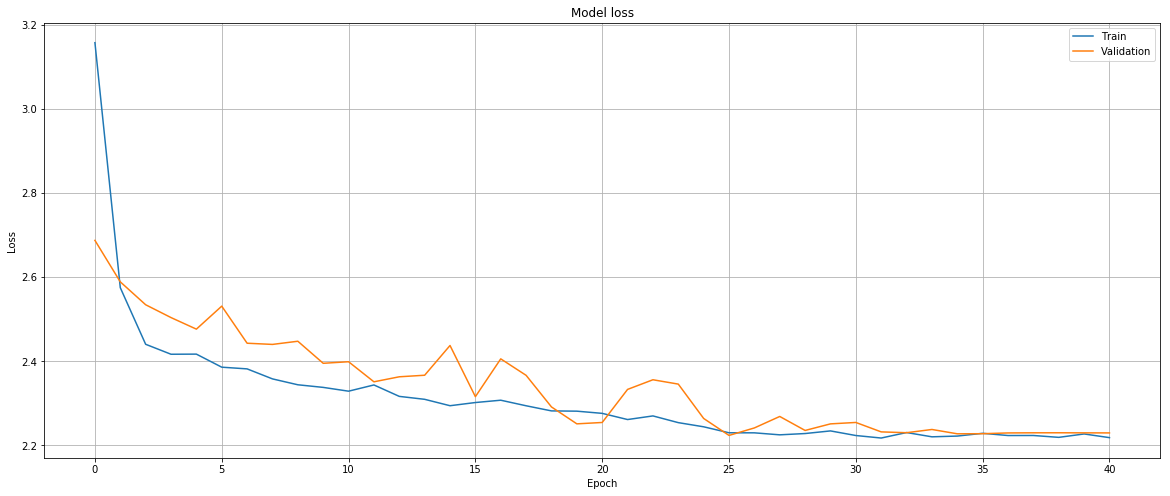

In [18]:
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

The lost of the model falls continuously and an over or underfitting is not visible. After that the reduction of the lost stagnates a bit, but continues to decrease steadily.
The model has also independently recognized that it comes to an overfitting and broke off the model. Info: The predictive value of new or data applied to our model is often based on the validation loss. This is therefore an indicator of how accurate our prediction values are. [[6]](#r6)

### Prediction<a id="prediction"></a>

Some test files exist in the **LANL-Earthquake-Prediction/test/** folder to predict when an earthquake will occur. Each test file has exactly 150.000 lines of data and represents a separate and independent sequence of randomly generated acoustic data. In the prediction, a separate prediction is created for each file. For this purpose, all files, including their contents, are first read in.

Reading in all test sequences can take some time (about five minutes).

In [19]:
test_sequence_length = 150000

test_files = [f for f in listdir(path_testData) if isfile(join(path_testData, f))]

test_data = np.empty([len(test_files), test_sequence_length])
test_ids = []
    
i = 0
for f in tqdm_notebook(test_files):
    test_ids.append(splitext(f)[0])
    t_df = pd.read_csv(path_testData + f, dtype={"acoustic_data": np.int16})
    test_data[i, :] = t_df['acoustic_data'].values
    i = i + 1

In [20]:
X_test = np.expand_dims(test_data, 2)
X_test.shape

(2624, 150000, 1)

Creating CNN model for Prediction

The 1D CNN model for prediction must correspond exactly to the 1D-CNN model in training except for one value. The only difference or change to the training model is in the argument `input_shape` of the first convolution layer. The argument `input_shape` must contain the length of the sequences and the number of channels of the input data. For the prediction, however, test sequences with a length of 150_000 are given. 

Remember: The training models had a sequence length of `sequence_length` (50_000).

In [21]:
model_prediction = Sequential()
model_prediction.add(Conv1D(filters=100, kernel_size=10, activation='relu',strides=5, input_shape=(test_sequence_length, num_features)))
model_prediction.add(MaxPooling1D(2))
model_prediction.add(Conv1D(filters=200, kernel_size=10, activation='relu',strides=5))
model_prediction.add(MaxPooling1D(2))
model_prediction.add(Conv1D(filters=400, kernel_size=10, activation='relu',strides=5))
model_prediction.add(GlobalAveragePooling1D())
model_prediction.add(Dropout(0.4))
model_prediction.add(Dense(1, activation='linear'))
model_prediction.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4))

In [26]:
model_prediction.load_weights('1d_cnn_model.h5')

Since the input sequences of the prediction model have a different sequence length, the training model cannot be used for the prediction. So a new model is created. In order to be able to use the results of the training model for the prediction, we have to be able to load them somehow into the prediction model. Loading the entire training model using the load_model method at this point would be very wasteful, since the entire training model would be loaded. As we have already learned, the possibility of learning a neural network is determined by adjusting the weights between the individual neurons in the network. This means that neurons connections that are more heavily loaded, e.g. because they often recognize patterns in training data and are therefore called more often, receive a greater weighting in this network than other neuron connections that are rarely used. In Python, these neuron connections are represented by simple matrices. The wih(weights between input and hidden layer) matrix contains the weights for the connections between the input and hidden layers and the who(weights between hidden and output layer) matrix contains the weights for the connections between the hidden layer and the output layer. When saving and also later when loading the weights into a model, these matrices are simply saved or loaded. The only important thing is that the parameters of the model (e.g. the number of layers or the filter sizes) are identical. Otherwise the saved matrices would no longer be compatible with the matrices of the new model. The model does not care if the input data are the same, because it only takes care that the matrices are compatible. You can also enter all data into a model, but if something comes out of it depends on whether the data is available in a form that can be used for the model. At this point you could have created a method that returns a model with different `input_shape` arguments. The advantage of this approach is that the training model can be calculated on a very strong machine (workstation/cloud), for example, and the prediction can take place on a weak machine such as a smartphone.

In [27]:
y_pred = model_prediction.predict(X_test)

The prediction now generates a probability value (number) for each test file, from when (after starting the sequence) an earthquake will occur.

The plot diagram provides an overview of the probability value of the test files. To do this, the lowest and highest values of the prediction value are taken and divided into equally wide ranges.
<br>**Index[0]:** Number of sequences in this area
<br>**Index[1]:** Median value of the time_to_failure of all sequences in this range

(array([ 15., 128., 670., 581., 329., 265., 213., 200., 154.,  69.]),
 array([-0.33714852,  0.7824451 ,  1.9020387 ,  3.0216322 ,  4.141226  ,
         5.2608194 ,  6.380413  ,  7.5000067 ,  8.6196    ,  9.739194  ,
        10.858788  ], dtype=float32),
 <a list of 10 Patch objects>)

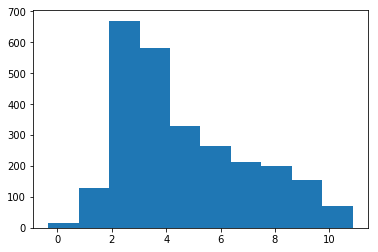

In [28]:
plt.hist(y_pred)

A negative value indicates that this test sequence did not cause an earthquake.

After the prediction is created for each test file, the prediction values are still saved in a CSV file. First, each prediction value (`time_to_failure`) is assigned to the corresponding test sequence (`seg_id`). 

In [29]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

The file is then saved.

In [30]:
submission_df.to_csv("my_prediction.csv", index=False)

## Compromise<a id="compromise"></a>

Because the time limit for submitting the model for this challenge had expired at the time of creation, the model could not compete directly with other models. However, since some of the developers have made their models freely available, we can compare our model this way. We were looking for a kernel that also uses CNN and has the best public score. The best model that was found was "Transformer Network With 1D-CNN Feature Extraction" by Siddhant Sarkar (https://www.kaggle.com/buchan/transformer-network-with-1d-cnn-feature-extraction) with a public score of 1.569. 

To compare the winner of the challenge had a public score of 1.08022. More information at: https://www.kaggle.com/c/LANL-Earthquake-Prediction/leaderboard.

In [2]:
myModel = pd.read_csv('my_prediction.csv', dtype={'seg_id': object, 'time_to_failure': np.float64})
compromiseModel = pd.read_csv('compromise_predicition.csv', dtype={'seg_id': object, 'time_to_failure': np.float64})

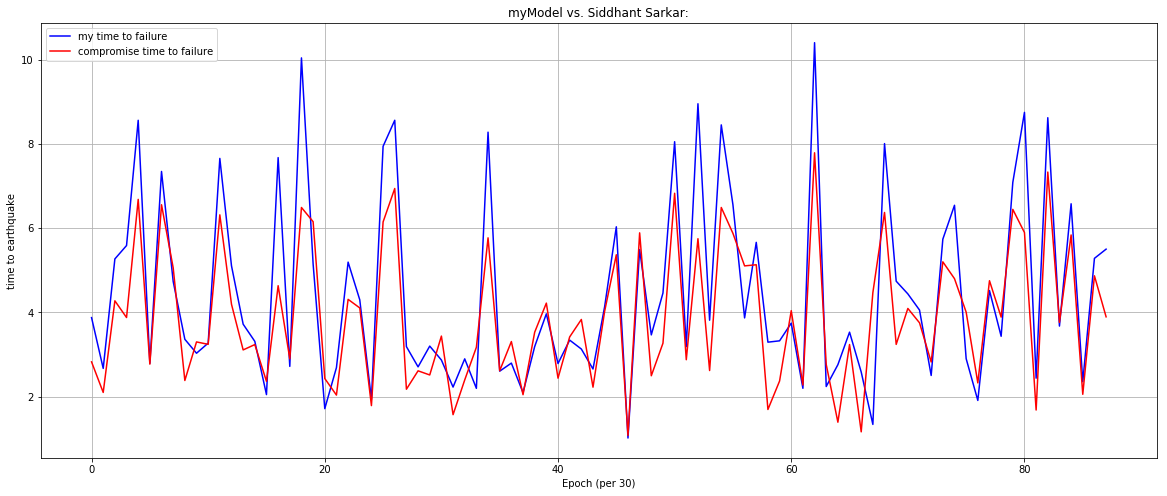

In [32]:
n_step = 30
myTimeToFailure = myModel['time_to_failure'].values[::n_step]
compromiseTimeToFailure = compromiseModel['time_to_failure'].values[::n_step]

fig = plt.subplots(figsize=(20, 8))
plt.title('myModel vs. Siddhant Sarkar:')
plt.plot(myTimeToFailure, color='b')
plt.plot(compromiseTimeToFailure, color='r')
plt.ylabel('time to earthquake')
plt.xlabel('Epoch (per 30)')
plt.legend(['my time to failure', 'compromise time to failure'], loc='upper left')
plt.grid(True)
plt.show()

The diagram shows that our model (blue) is quite close to the model of Siddhant Sarkar (red). If you look at the structure of the two models, you will notice that our model has a quite simple structure compared to the comparison model. For a better comparison: Under the link of Siddhant Sarka you can find the structure of the model. 

*Conclusion:* Although our model is very simple and doesn't contain any extra features, it provides predictive values that show similarities in the course. However, the difference is mainly visible in the peaks and swings (up and down). At these peaks, the models often show different values or a slightly different course for a short time. Whether our model or Siddhant Sarkar's model provides the "more accurate" values cannot be said. Our model would have had to take part in the challenge so that the scores could be compared.


## Summary<a id="summary"></a>
Let's recap what we have learned in this tutorial:

- What is kaggle
- Explore Dataset
- Load and Prepare Data
- Build a simple 1D-CNN sequential model
- Prediction Data

## References<a id="references"></a>

### Code
[1] https://www.youtube.com/watch?v=TffGdSsWKlA<a id="r1"></a><br>
[5] https://www.kaggle.com/buchan/transformer-network-with-1d-cnn-feature-extraction<a id="r5"></a><br>
[6] https://www.kaggle.com/adubitskiy/rnn-with-cnn-feature-extraction/notebook<a id="r6"></a><br>
[7] https://github.com/llSourcell/Kaggle_Earthquake_challenge/blob/master/Earthquake_Challenge.ipynb<a id="r7"></a><br>
[8] https://www.kaggle.com/fanconic/earthquake-cnn/output<a id="r8"></a><br>

### Explanations
[2] https://keras.io/layers/convolutional/<a id="r2"></a><br>
[3] https://keras.io/layers/pooling/<a id="r3"></a><br>
[4] https://medium.com/@abhigoku10/activation-functions-and-its-types-in-artifical-neural-network-14511f3080a8<a id="r4"></a><br>

___
## All-in-one solution

In [ ]:
#
# Load packages
#
from __future__ import print_function
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#data visualization
import matplotlib.pyplot as plt
#host-os operations
import os
from os import listdir, makedirs, path
from os.path import isfile, join, basename, splitext, isfile, exists
from pathlib import Path
#import keras.utils as utils
from tqdm import tqdm_notebook
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Embedding, GlobalAveragePooling1D
from keras.optimizers import adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from keras import optimizers
# Graphic output
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#
# Prepare data
#
Earthquake_Prediction = Path('LANL-Earthquake-Prediction')
Test = Path('LANL-Earthquake-Prediction/test/')

if Earthquake_Prediction.is_dir() and Test.is_dir():
    print('Data already available')
else:
    import zipfile
    zip_ref = zipfile.ZipFile('LANL-Earthquake-Prediction.zip', 'r')
    zip_ref.extractall('LANL-Earthquake-Prediction')
    zip_ref.close()
print(os.listdir('LANL-Earthquake-Prediction'))
print("There are {} files in test folder".format(len(os.listdir(os.path.join('LANL-Earthquake-Prediction', 'test' )))))

num_sequences = 629000000
sequence_length= 50000
num_features = 1
batch_size = 128
epochs = 100
path_trainData = 'LANL-Earthquake-Prediction/'
path_testData = 'LANL-Earthquake-Prediction/test/'
#
# Load Data
#
load_data = pd.read_csv(path_trainData+'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(load_data.head(10))
print('\n')
print(load_data.tail(10))
#
# Data exploration
#
n_step = 100
train_ad_sample_df = load_data['acoustic_data'].values[::n_step]
train_ttf_sample_df = load_data['time_to_failure'].values[::n_step]

fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title('Acoustic data:')
plt.plot(train_ad_sample_df, color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title('time to failure:')
plt.plot(train_ttf_sample_df, color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(20, 8))
plt.title('Acoustic data and time to failure:')
plt.plot(train_ad_sample_df, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(train_ttf_sample_df, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)
plt.show()
#
# Informtion
#
from IPython.display import YouTubeVideo
YouTubeVideo('m_dBwwDJ4uo')
#
# Prepare Data
#
train = load_data[:num_sequences]
#Training data for 1D-CNN
X_train = train['acoustic_data'].values
Y_train = train['time_to_failure'].values
print(X_train.shape,Y_train.shape)

#Read values and reshape
X_train = X_train.reshape(-1,sequence_length,num_features)
Y_train = Y_train.reshape(-1,sequence_length,num_features)

#
mean = np.zeros(len(Y_train), dtype = float) 
for i in range(len(Y_train)):
    if(abs(Y_train[i][0]-Y_train[i][-1]) < 0.00000001):
        mean[i] = 0
    else:
        mean[i] = (float(Y_train[i][0])+float(Y_train[i][-1]))/2
        
Y_train = np.float32(mean) 
print(X_train.shape,Y_train.shape)
#
# Build model
#
model = Sequential()
model.add(Conv1D(filters=100, kernel_size=10, activation='relu',strides=5, input_shape=(sequence_length, num_features)))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=200, kernel_size=10, activation='relu',strides=5))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=400, kernel_size=10, activation='relu',strides=5))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
#model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
model.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4))
#print(model.summary())
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))
#
# train model
#
history = model.fit(X_train, Y_train.reshape(-1,1), batch_size=batch_size, epochs=epochs, validation_split=0.3, verbose = 1,
                    callbacks = [
                        EarlyStopping(monitor='val_loss',patience=15, verbose=1, mode='min'),
                        ModelCheckpoint(filepath='1d_cnn_model', monitor='val_loss', mode='min', save_best_only=True, verbose=1),
                        ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=1,min_delta=1e-4,mode='min')])
#
# Plot 
#
history_dict = history.history
history_dict.keys()
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Validation'], loc='lower left')
#
# Prediction
#
test_sequence_length = 150000
test_files = [f for f in listdir(path_testData) if isfile(join(path_testData, f))]
test_data = np.empty([len(test_files), test_sequence_length])
test_ids = []
i = 0
for f in tqdm_notebook(test_files):
    test_ids.append(splitext(f)[0])
    t_df = pd.read_csv(path_testData + f, dtype={"acoustic_data": np.int16})
    test_data[i, :] = t_df['acoustic_data'].values
    i = i + 1

X_test = np.expand_dims(test_data, 2)
X_test.shape
#
# build prediction model
#
model_prediction = Sequential()
model_prediction.add(Conv1D(filters=100, kernel_size=10, activation='relu',strides=5, input_shape=(test_sequence_length, num_features)))
model_prediction.add(MaxPooling1D(2))
model_prediction.add(Conv1D(filters=200, kernel_size=10, activation='relu',strides=5))
model_prediction.add(MaxPooling1D(2))
model_prediction.add(Conv1D(filters=400, kernel_size=10, activation='relu',strides=5))
model_prediction.add(GlobalAveragePooling1D())
model_prediction.add(Dropout(0.4))
model_prediction.add(Dense(1, activation='linear'))
model_prediction.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4))
model_prediction.load_weights(path_model+'1d_cnn_model.h5')
#
# prediction
#
y_pred = model_prediction.predict(X_test)
plt.hist(y_pred)
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})
submission_df.to_csv("my_prediction.csv", index=False)
#
# Compromise
#
myModel = pd.read_csv('my_prediction.csv', dtype={'seg_id': object, 'time_to_failure': np.float64})
compromiseModel = pd.read_csv('compromise_predicition.csv', dtype={'seg_id': object, 'time_to_failure': np.float64})
n_step = 30
myTimeToFailure = myModel['time_to_failure'].values[::n_step]
compromiseTimeToFailure = compromiseModel['time_to_failure'].values[::n_step]

fig = plt.subplots(figsize=(20, 8))
plt.title('myModel vs. Siddhant Sarkar:')
plt.plot(myTimeToFailure, color='b')
plt.plot(compromiseTimeToFailure, color='r')
plt.ylabel('time to earthquake')
plt.xlabel('Epoch (per 30)')
plt.legend(['my time to failure', 'compromise time to failure'], loc='upper left')
plt.grid(True)
plt.show()